In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2

# use seaborn plotting defaults
import seaborn as sns; sns.set()

In [2]:
import glob
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


Загрузим датасет и сформируем выборку для решения задачи.
При загрузке фотографий приведем все фотографии к размеру 64x64 пикселя.

In [4]:
# read directory and make x, y lists

dirname = "/gdrive/My Drive/Start_ML"
labels = ['Sofia_Sekhova', 'Trifonov_Vasilij', 'Алиса', 'Denis G', 'Sergey', 'Даниил', 'Дарья Агапенкова', 'Kate_A', 'Maxim Filatov', 'Ди']

x, y = [], []

for label in labels:
    
    subdir = os.path.join(dirname, label)
    filelist = os.listdir(subdir)
    
    for fname in filelist:
        img = cv2.imread(os.path.join(subdir, fname), cv2.IMREAD_GRAYSCALE)
        
        h, w = img.shape
        size = min(h, w)
        h0 = int((h - size) / 2)
        w0 = int((w - size) / 2)
        
        img = img[h0: h0 + size, w0: w0 + size]
        img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
        
        x.append(img)
        y.append(label)
len(x), len(y)

(505, 505)

Переведем названия классов в целые числа от 0 до 9 (у нас 10 классов)


In [5]:
labels = {'Sofia_Sekhova': 0, 'Trifonov_Vasilij': 1, 'Алиса': 2, 'Denis G': 3, 'Sergey': 4, 'Даниил': 5, 'Дарья Агапенкова': 6, 'Kate_A': 7, 'Maxim Filatov': 8, 'Ди': 9}

y = [labels[item] for item in y]

Нарисуем первые три изображения

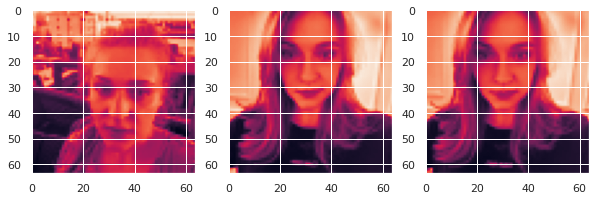

In [10]:
fig, axx = plt.subplots(1, 3, figsize=(10, 5))

for i in range(3):
    img = x[i]
    axx[i].imshow(img)

В матрице объект-признак признаки объекта расположены в строке. Поэтому необходимо "растянуть" каждое изображение в вектор длины  64⋅64 .

In [19]:
data = np.asarray([el.ravel() for el in x])

Разобъем данные на обучающую и тестовые выборки, сохранив баланс классов (stratify = y)

In [20]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(data, y, stratify = y, random_state=42)

Baseline

Обучим логистическую регрессию и оценим её качество (выборка сбалансированная, поэтому используем метрику accuracy).

In [21]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(Xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [23]:
from sklearn.metrics import accuracy_score, f1_score

pred_lr = model_lr.predict(Xtest)

accuracy_score(ytest, pred_lr)

0.6377952755905512

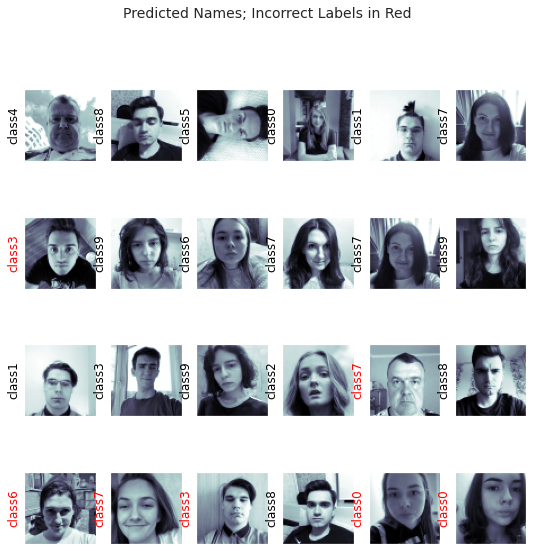

In [24]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(64, 64), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel('class'+str(pred_lr[i]),
                   color='black' if pred_lr[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [25]:
# проверка на сбалансированность
from collections import Counter
Counter(ytest)

Counter({0: 13, 1: 15, 2: 9, 3: 13, 4: 13, 5: 13, 6: 12, 7: 13, 8: 14, 9: 12})

Расширенная оценка качества baseline

In [26]:
from sklearn.metrics import classification_report
print(classification_report(ytest, pred_lr,
                            target_names=labels))

                  precision    recall  f1-score   support

   Sofia_Sekhova       0.56      0.69      0.62        13
Trifonov_Vasilij       0.93      0.87      0.90        15
           Алиса       0.50      0.22      0.31         9
         Denis G       0.54      0.54      0.54        13
          Sergey       0.82      0.69      0.75        13
          Даниил       0.56      0.69      0.62        13
Дарья Агапенкова       0.44      0.33      0.38        12
          Kate_A       0.57      0.62      0.59        13
   Maxim Filatov       0.76      0.93      0.84        14
              Ди       0.54      0.58      0.56        12

        accuracy                           0.64       127
       macro avg       0.62      0.62      0.61       127
    weighted avg       0.63      0.64      0.63       127



Чтобы понять, каких людей алгоритм лучше всего детектирует, а каких путает и с кем - можно нарисовать матрицу ошибок, которая отражает эту информацию.

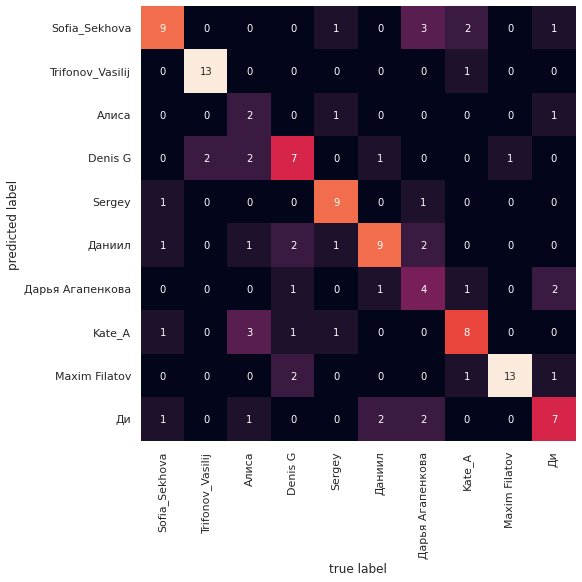

In [27]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,8))
mat = confusion_matrix(ytest, pred_lr)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label');